##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
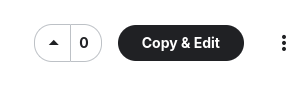
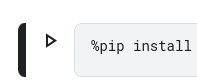

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [2]:
!pip uninstall -qqy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [3]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
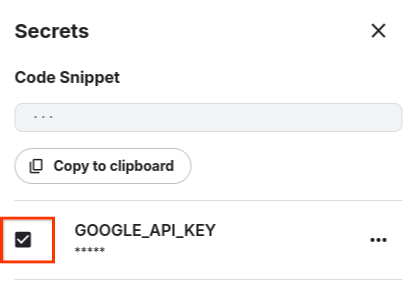

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Explain AI to me like I'm a kid.")

print(response.text)

Imagine you have a really, really smart toy robot.  This robot can learn new things just by seeing or hearing them, like when you teach your puppy to sit! 

That's kind of what AI is!  It's like teaching a computer to think and learn like a person.

Instead of just following instructions like a normal computer, AI can:

* **See things:**  Like knowing if a picture is of a cat or a dog.
* **Hear things:**  Like understanding what you're saying, even if you don't say it perfectly.
* **Learn from mistakes:** If it gets something wrong, it can figure out why and try again!
* **Make decisions:**  Like choosing the best move in a game or suggesting a funny video you might like.

So, AI is like a super smart computer program that can learn and think on its own, helping us do lots of cool things!  It's what makes your tablet understand your voice, and what helps robots clean up messes!  Isn't that neat?



The response often comes back in markdown format, which you can render directly in this notebook.

In [7]:
Markdown(response.text)

Imagine you have a really, really smart toy robot.  This robot can learn new things just by seeing or hearing them, like when you teach your puppy to sit! 

That's kind of what AI is!  It's like teaching a computer to think and learn like a person.

Instead of just following instructions like a normal computer, AI can:

* **See things:**  Like knowing if a picture is of a cat or a dog.
* **Hear things:**  Like understanding what you're saying, even if you don't say it perfectly.
* **Learn from mistakes:** If it gets something wrong, it can figure out why and try again!
* **Make decisions:**  Like choosing the best move in a game or suggesting a funny video you might like.

So, AI is like a super smart computer program that can learn and think on its own, helping us do lots of cool things!  It's what makes your tablet understand your voice, and what helps robots clean up messes!  Isn't that neat?


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [8]:
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Kai.')
print(response.text)

Hi Kai! It's nice to meet you. How can I help you today?



In [9]:
response = chat.send_message('Can you tell me something interesting about dinosaurs?')
print(response.text)

Okay, here's an interesting fact about dinosaurs:

**Some dinosaurs, like the Microraptor, had four wings!**

While most people think of dinosaurs as having two legs or two legs and two arms, Microraptor gui, a small, feathered dinosaur from the Early Cretaceous period, had feathers on both its arms and legs, essentially giving it four wings. Scientists believe it used these wings to glide and potentially fly short distances, similar to a modern-day flying squirrel.

Isn't that fascinating? It really shows how diverse and surprising the world of dinosaurs was!



While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [10]:
response = chat.send_message('Do you remember what my name is?')
print(response.text)

Yes, your name is Kai.



### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [11]:
for model in client.models.list():
  print(model.name)

models/embedding-gecko-001
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robo

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [12]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent',
                       'countTokens',
                       'createCachedContent',
                       'batchGenerateContent'],
 'tuned_model_info': {},
 'version': '2.0'}


In [13]:
for model in client.models.list():
  if model.name == 'models/gemini-2.5-flash-lite':
    pprint(model.to_json_dict())
    break

{'description': 'Stable version of Gemini 2.5 Flash-Lite, released in July of '
                '2025',
 'display_name': 'Gemini 2.5 Flash-Lite',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.5-flash-lite',
 'output_token_limit': 65536,
 'supported_actions': ['generateContent',
                       'countTokens',
                       'createCachedContent',
                       'batchGenerateContent'],
 'tuned_model_info': {},
 'version': '001'}


## Explore generation parameters



### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [14]:
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a 1000 word essay on the importance of olives in modern society.')

print(response.text)

## The Humble Olive: A Cornerstone of Modern Society

The olive, a fruit of antiquity, continues to hold a surprisingly prominent and multifaceted position in modern society. Far from being a mere appetizer or a source of culinary oil, the olive tree, its fruit, and its derived products play critical roles in our economy, health, culture, and even environmental sustainability. Understanding the importance of olives requires a deep dive into their economic significance, their health-promoting properties, their cultural resonance, and their potential contribution to a more sustainable future.

Economically, the olive industry represents a significant global market. Olive oil, the primary product derived from olives, is a billion-dollar industry, with major producers like Spain, Italy, Greece, Tunisia, and Turkey contributing significantly to global trade. Beyond the production of olive oil, the market for table olives, both green and black, is also substantial. From gourmet specialty sto

In [15]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem on the importance of olives in modern society.')

print(response.text)

From groves of ancient, sun-kissed grace,
The olive comes, a timeless face.
In salads bright, or oils so pure,
A healthy life it does assure.

On pizzas spread, a savory treat,
Or tapenades, oh so complete.
A symbol too, of peace and might,
The olive shines, a guiding light.

So raise a glass, of olive hue,
To this small fruit, forever true,
In modern meals, it plays its part,
A healthy treasure, close to heart.



Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

In [16]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem in 100 words on the importance of AI in modern society.')

print(response.text)

In circuits deep, a mind takes hold,
AI awakes, a story told.
No longer just a distant dream,
It weaves its way into life's stream.

From tasks mundane to grand design,
A helping hand, a guiding sign.
Machines that learn, adapt, and grow,
Efficiency's seeds they bravely sow.

In medicine, a watchful eye,
In space, it helps us touch the sky.
Connecting minds across the globe,
A digital, expanding robe.

Yet caution whispers, soft and low,
With power great, responsibility must grow.
A future shaped by code's embrace,
AI's impact marks our human race.



### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [17]:
high_temp_config = types.GenerateContentConfig(temperature=2.0)


for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Mauve
 -------------------------
Azure
 -------------------------
Purple
 -------------------------
Cerulean
 -------------------------
Orange.
 -------------------------


Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [18]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------


### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [19]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story in 100 words about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a ginger tabby of refined tastes (mostly tuna), found boredom clawing at her paws. One Tuesday, she slipped out the window. The world exploded with scent: damp earth, chirping sparrows, and something wildly intriguing emanating from the forbidden woods.

She ventured in, emerald eyes wide. Sunlight dappled through leaves, illuminating a hidden stream. There, balanced precariously on a mossy rock, was a ruby-throated hummingbird, wings a blur. Clementine, forgetting her predatory instincts, watched, mesmerized. 

The bird zipped away. Clementine, content, retraced her steps, the taste of adventure sweeter than any tuna. Home never seemed so cozy.



In [20]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=0,
    top_p=0,
)

story_prompt = "You are a creative writer. Write a short story in 100 words about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Jasper, a ginger tabby, was tired of naps. One sun-drenched afternoon, he slipped out the window. The world exploded with scent: damp earth, blooming roses, and something wild. He stalked through tall grass, a tiny tiger in a green jungle. A butterfly, wings like stained glass, led him to a babbling brook. He batted at the water, a playful splash. Suddenly, a rustle! A field mouse, plump and tempting. Jasper pounced, a thrilling chase ending in a near miss. Disappointed but exhilarated, he turned for home, the setting sun painting the sky in fiery hues, a seasoned adventurer.



## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [21]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment: """

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

POSITIVE



#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [22]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "positive"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

positive


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [23]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.POSITIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [24]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])

print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [25]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large dessert pizza with apple and chocolate")

print(response.text)

{
  "size": "large",
  "ingredients": ["apple", "chocolate"],
  "type": "dessert"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [26]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now, I
am 20 years old. How old is my partner? Return the answer directly."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

print(response.text)

48



Now try the same approach, but indicate to the model that it should "think step by step".

In [27]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now,
I am 20 years old. How old is my partner? Let's think step by step."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Here's how to solve the problem step-by-step:

1.  **Find the age difference:** When you were 4, your partner was 3 times your age, so they were 4 * 3 = 12 years old.
2.  **Calculate the age difference:** The age difference between you and your partner is 12 - 4 = 8 years.
3.  **Determine partner's current age:** Since the age difference remains the same, your partner is currently 20 + 8 = 28 years old.

**Answer:** Your partner is 28 years old.


### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [28]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [29]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to find the transformers NLP paper and then find the youngest author listed on that paper.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [30]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
I have the list of authors. I need to find their ages and the youngest age to answer the question. I will start with the first author, Ashish Vaswani.

Action 2
<search>Ashish Vaswani age</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [31]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-exp',
    contents='Who was the youngest author listed on the original transformers NLP paper?',
)

buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    # Display the response as it is streamed
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

The original Transformers NLP paper, "Attention is All You Need" (Vaswani et al., 2017), lists the authors in the following order:

Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin.

Based on available information and common knowledge within the NLP community, **Aidan N. Gomez** was likely the youngest author on the paper. He was a Ph.D. student at the University of Oxford at the time of publication. While precise ages at the time of publication aren't readily available, the fact that he was a PhD student while the others were more established researchers strongly suggests he was the youngest.


## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [32]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a Python function to calculate the factorial of a number. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
def factorial(n):
  """
  Calculate the factorial of a number.
  """
  if n == 0:
    return 1
  else:
    return n * factorial(n-1)
```

### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [33]:
from pprint import pprint

config = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the first 14 odd prime numbers, then calculate their sum.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': "Okay, I can do that. First, I'll list the first 14 odd prime "
         'numbers. Remember that a prime number is a number greater than 1 '
         'that has only two factors: 1 and itself. Also, the number 2 is the '
         'only even prime number. Since you asked for odd prime numbers, I '
         'will start with 3.\n'
         '\n'
         'The first 14 odd prime numbers are: 3, 5, 7, 11, 13, 17, 19, 23, 29, '
         '31, 37, 41, 43, 47\n'
         '\n'
         "Now, let's calculate their sum using a python code block.\n"
         '\n'}
-----
{'executable_code': {'code': 'numbers = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, '
                             '37, 41, 43, 47]\n'
                             'sum_of_numbers = sum(numbers)\n'
                             "print(f'{sum_of_numbers=}')\n",
                     'language': 'PYTHON'}}
-----
{'code_execution_result': {'outcome': 'OUTCOME_OK',
                           'output': 'sum_of_numbers=326\n'}}
-----
{'tex

This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [34]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I can do that. First, I'll list the first 14 odd prime numbers. Remember that a prime number is a number greater than 1 that has only two factors: 1 and itself. Also, the number 2 is the only even prime number. Since you asked for odd prime numbers, I will start with 3.

The first 14 odd prime numbers are: 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47

Now, let's calculate their sum using a python code block.



```python
numbers = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_numbers = sum(numbers)
print(f'{sum_of_numbers=}')

```

```
sum_of_numbers=326

```

The sum of the first 14 odd prime numbers is 326.


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [35]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what this file does at a very high level. What is it, and why would I use it?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This is a Bash script designed to enhance your command-line prompt with Git repository status information.  It provides a visually informative prompt that shows things like the current branch, whether there are uncommitted changes, how far ahead or behind you are from the remote repository, and other relevant Git-related details.

Here's a breakdown of its purpose and usage:

**What it is:**

*   **Git Prompt Customization:** The script customizes your shell prompt to display Git-related information directly in the prompt.
*   **Shell Compatibility:** The code supports bash and zsh.
*   **Theming:** It has the ability to customize the prompt's colors and symbols through theming.

**Why you'd use it:**

*   **Real-time Git Status:**  Instantly see the status of your Git repository without having to run `git status` manually. This is much faster.
*   **Improved Workflow:**  A glance at the prompt tells you everything you need to know about your Git environment, streamlining your workflow.
*   **Visual Indicators:** Color-coded information makes it easier to identify important aspects of your repository's state (e.g., uncommitted changes in red).
*   **Customization:**  Configure the prompt to show the information that's most important to *you* through themes.
*   **Virtual Environment awareness:** it's can display virtual environment information.

**How it works (simplified):**

1.  **Loads Configuration:** It reads configuration files that define colors, symbols, and which information to display.
2.  **Detects Git Repository:** It checks if the current directory is a Git repository.
3.  **Fetches Git Status:** It uses Git commands to gather information about the repository's status (branch name, changes, etc.).
4.  **Formats Prompt:** It assembles the prompt string using the gathered Git information, colors, and symbols.
5.  **Sets Prompt:** It sets the `PS1` environment variable (the primary prompt string) to the newly formatted prompt.  `PS1` is what determines the look of your command line.

**In short:** This script gives you a fancy, informative command-line prompt that makes working with Git repositories much more intuitive.


## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*